## Python Libraries 

In [75]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [76]:
# Load general utilities
# ----------------------
import pandas as pd
import datetime
import numpy as np
import pickle
import time

In [77]:
# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.tree import DecisionTreeClassifier

In [78]:
# Other Packages
# --------------
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [79]:
# Local Packages
# --------------
from helpers_05_08 import visualize_tree
from helpers_03_19 import prepare_data

## Load the data 

Read the data and features from the pickle

                   data - Pandas DataFrame with the data ingested
                           in the previous 
      discrete_features - list of discrete features: 
                           'term','grade',etc.
continuous_features - list of continuous features:
                           'loan_amnt','funded_amnt','installment',etc.


In [116]:
data,discrete_features,continuous_features,ret_cols=\
    pickle.load(open("./data/pickle/clean_data.pickle","rb"))

## Engineer features

Create a feature for the length of a person's credit history at the
time the loan is issued and add feature to list of continuous features

In [117]:
data['cr_hist']=(data.issue_d-data.earliest_cr_line)/np.timedelta64(1,'M')
continuous_features.append('cr_hist')

Create a target feature on whether loan ended in default

In [118]:
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

### Partition  Data into training and testing

Genearte a random vector of boolian values based in which
rows are assigned to either train or test

In [119]:
default_seed = 1
np.random.seed(default_seed)
data['train']=np.random.choice([True, False],size=len(data),p=[0.7, 0.3])
train = data.train.values

Convert pandas sub dataframe of continuous_features to a numpy matrix

In [120]:
X_continuous=data[continuous_features].values

Use pandas built in functionality to replace discrte variables with k vlaues with k discrete dummy (0/1) variables, keep a record of dummy variables created in this way and convert the resulting pandas sub dataframe of dummy variables into a numpy matrix

In [121]:
df_discrete=pd.get_dummies(data[discrete_features],\
                            dummy_na = True, prefix_sep = "::",\
                            drop_first = False)
discrete_features_dummies = df_discrete.columns.tolist()
X_discrete=df_discrete.values

Pull together the discrete and contiuous values into one 
matrix and create another matrix with the target values 

In [122]:
X=np.concatenate( (X_continuous, X_discrete), axis = 1 )
y=data.outcome.values

### Problem 1
Write a script that verifies that the dummy variable conversion is correct.
1. write a script that lists all the dummy variables related to a discrete variable
    e.g. ['grade::A','grade::B',...] 
2. verify variables in list have values o or 1
3. verify variables in list add up to one

In [41]:
###############################
###   Write your code  here  ##
###############################



###############################

## Prepare functions to fit and evaluate models

'final_features' is the list of features that are used, we could chose to exclude certain features to prevent leakage or exclude features that are laready dependant on models (such as grade)

In [211]:
exclusion=['grade','int_rate']
#exclusion=[]
final_features=[i for i in discrete_features + continuous_features\
                  if i not in exclusion]

In [212]:
data_dict =prepare_data(X,y,\
            data_subset = np.array([True]*len(data)),\
            n_samples_train=30000,n_samples_test=20000,\
            feature_subset=final_features,
            continuous_features=continuous_features,
            discrete_features_dummies=discrete_features_dummies,
            data=data,
            date_range_train=(data.issue_d.min(),data.issue_d.max()),
            date_range_test=(data.issue_d.min(),data.issue_d.max()),
            random_state=default_seed)

In [213]:
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i,j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [214]:
random_state=default_seed
np.random.seed(random_state)
X_train=data_dict['X_train']
y_train=data_dict['y_train']   
X_test=data_dict['X_test']
y_test=data_dict['y_test']
filter_train=data_dict['train_set']    

# Information Gain

## Problem 2

##### Write the code for a method:<br>

   >**<font color=blue>findInformationGain</font>(<font color=brown> selected_feature,threshold,y_train,X_train</font>)**<br>

 where X and y are matrices and vectors as above, _feature_ is a string and   _threshold_ is a float

e.g.:
> <font color=blue>findInformationGain</font>
(<font color=brown>'fico_range_high',710,y_train,X_train</font>)=0.010126<br>
> <font color=blue>findInformationGain</font>(<font color=brown>'term:: 60 months',0.5,y_train,X_train</font>)=0.008358<br>
> <font color=blue>findInformationGain</font>(<font color=brown>'term:: 36 months',0.5,y_train,X_train</font>)=0.008358<br>
> <font color=blue>findInformationGain</font>(<font color=brown>'grade::E',0.495,y_train,X_train</font>)=0.007554<br>



In [212]:
###############################
###   Write your code  here  ##
###############################



###############################

## Problem 3

For at least one continuous feature, chart the information gain vs threshold par chart below

<img src="InfoGain.png" alt="Alt text that describes the graphic" title="Title text" />


In [ ]:
###############################
###   Write your code  here  ##
###############################



###############################

## Problem 4
##### Write the code for a method:<br>

   >**<font color=blue>maxInformationGain</font>(<font color=brown> selected_feature,y_train,X_train</font>)**<br>


the method finds the range of values the feature takes, computes the information gain for one hundered data points/thresholds evenly dispersed within this range and finds the closest to optimal threshold


In [ ]:
###############################
###   Write your code  here  ##
###############################



###############################

In [215]:
def maxInformationGain(selected_feature,y_train,X_train):
    mymin=int(min(X_train.T[selected_features==selected_feature][0]))
    mymax=int(max(X_train.T[selected_features==selected_feature][0]))
    b=np.sum(y_train)/len(y_train)
    eb=-b*np.log(b)-(1-b)*np.log(1-b)
    gg={}
    for tt in range(100):
        thrshld=mymin+tt*(mymax-mymin)/100
        below_threshld=(X_train.T[selected_features==selected_feature]<=thrshld)[0]
        if np.sum(below_threshld)>0:
            pbelow=np.sum(below_threshld)/len(below_threshld)
            p0=np.sum(y_train[below_threshld])/np.sum(below_threshld)
        else:
            pbelow=0
            p0=0
        if p0>0:
            if p0<1:
                ep0=-p0*np.log(p0)-(1-p0)*np.log(1-p0)
            else:
                ep0=0
        else:
            ep0=0
        above_threshld=(X_train.T[selected_features==selected_feature]>thrshld)[0]
        if np.sum(above_threshld)>0:
            pabove=np.sum(above_threshld)/len(above_threshld)
            p1=np.sum(y_train[above_threshld])/np.sum(above_threshld)
        else:
            pabove=0
            p1=0
        if p1>0:
            if p1<1:
                ep1=-p1*np.log(p1)-(1-p1)*np.log(1-p1)
            else:
                ep1=0
        else:
            ep1=0
        gg[thrshld]=eb-pbelow*ep0-pabove*ep1
    return(pd.Series(gg))

Use the following script to create a table of the information gain of each feature and sort the list by information gain

In [216]:
feature_lst=[]
for select_feature in selected_features:
    gg=maxInformationGain(select_feature,y_train,X_train)
    feature_lst.append({'feature':select_feature,
                       'threshold':np.mean(gg[gg==np.max(gg)].index),
                       'information_gain':np.max(gg)})
df=pd.DataFrame(feature_lst,columns=['feature','threshold','information_gain'])
df.sort_values(by='information_gain',ascending=False).head(8)


,feature,threshold,information_gain
9,fico_range_high,711.430,0.010126
10,fico_range_low,708.100,0.010126
18,term:: 60 months,0.495,0.008358
17,term:: 36 months,0.495,0.008358
4,dti,24.400,0.006710
47,home_ownership::MORTGAGE,0.495,0.004604
13,verification_status::Not Verified,0.495,0.004209
49,home_ownership::RENT,0.495,0.004176


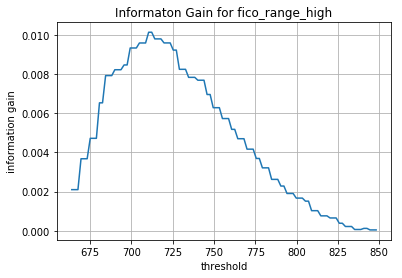

In [217]:
gg=maxInformationGain('fico_range_high',y_train,X_train)
fig, ax = plt.subplots()
ax.plot(gg)
ax.grid()
ax.set(xlabel='threshold', ylabel='information gain',
       title='Informaton Gain for fico_range_high')
fig.savefig("InfoGain.png")
plt.show()
print()

# Decision Tree

As discussed in class, the decision tree object is **instantiated** by a call to 'number_of_leaf_nodes'. Upon instantiation we provide some of the parameters, most important of which is the number of nodes.

In [230]:
number_of_leaf_nodes=3
decision_tree=DecisionTreeClassifier(max_leaf_nodes=number_of_leaf_nodes,\
                                     criterion='entropy')


After instantiation, we would like to **'fit'** the model, namely compute the coefficients of the underlying model. The time measurements is for our own track of execution time and will not be used subsequently. 

In [231]:
start_time=time.time()
decision_tree=decision_tree.fit(X_train, y_train)
end_time=time.time()
print("Fit time: "+str(round(end_time-start_time,2))+" seconds")

Fit time: 0.08 seconds


### Tree representation
The script below prints the raw unstructured representation of a decision tree in the model,aka the tree coefficiants 

In [232]:
def rawPrint(decision_tree):
    n_nodes=decision_tree.tree_.node_count
    children_left=decision_tree.tree_.children_left
    children_right=decision_tree.tree_.children_right
    feature=decision_tree.tree_.feature
    threshold=decision_tree.tree_.threshold

    print('children_left:\t',children_left)
    print('children_right:\t',children_right)
    print('feature #:\t',feature)
    print('threshold:\t',[float((str(n).split('.'))[0]+'.'\
                 +(str(n).split('.'))[1][:2])\
           for n in list(threshold)]) 
    print('features used in the tree:')
    for i in feature:
        if i>0:
            print('\t',i,selected_features[i])
    return

rawPrint(decision_tree)

children_left:	 [ 1  3 -1 -1 -1]
children_right:	 [ 2  4 -1 -1 -1]
feature #:	 [10 17 -2 -2 -2]
threshold:	 [707.5, 0.5, -2.0, -2.0, -2.0]
features used in the tree:
	 10 fico_range_low
	 17 term:: 36 months


In [233]:
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
n_nodes=decision_tree.tree_.node_count
children_left=decision_tree.tree_.children_left
children_right=decision_tree.tree_.children_right
feature=decision_tree.tree_.feature
threshold=decision_tree.tree_.threshold
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id,parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

In [234]:
print("The binary tree structure has %s nodes with the\
following structure:"% n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf" % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test: if %s<=%.2f goto node %s else to "
              "node %s"
              % (node_depth[i] * "\t",i,
                 selected_features[feature[i]],threshold[i],
                 children_left[i],
                 children_right[i],))
print()

The binary tree structure has 5 nodes with thefollowing structure:
node=0 test: if fico_range_low<=707.50 goto node 1 else to node 2
	node=1 test: if term:: 36 months<=0.50 goto node 3 else to node 4
	node=2 leaf
		node=3 leaf
		node=4 leaf



In [235]:
leave_id = decision_tree.apply(X_test)
pd.DataFrame({'leave':leave_id,'label':y_test}).groupby(['leave']).mean()

,label
leave,
2,0.162920
3,0.411017
4,0.258824


In [225]:
# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = decision_tree.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = decision_tree.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 34
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

In [226]:
print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s,%s] %s (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             selected_features[feature[node_id]],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

#common_node_id = np.arange(n_nodes)[common_nodes]

#print("\nThe following samples %s share the node %s in the tree"
#      % (sample_ids, common_node_id))
#print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

Rules used to predict sample 34: 
decision id node 0 : (X_test[34,10] fico_range_low (= 720.0) > 707.5)
decision id node 2 : (X_test[34,17] term:: 36 months (= 1.0) > 0.5)


In [185]:
VALUES = [733948.45278935181, 733948.45280092594, 733948.45280092594]
for v in VALUES:
    print('%.3f'%(v))

733948.453
733948.453
733948.453


In [192]:
 print("'%06s'"%'sd')

'    sd'


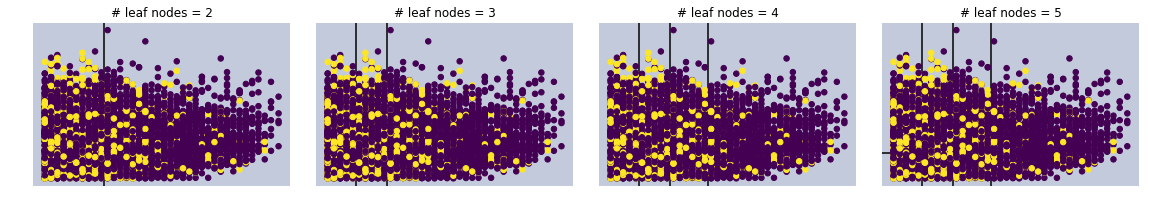

In [296]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)


for axi, number_of_leaf_nodes in zip(ax, range(2, 6)):
    decision_tree=DecisionTreeClassifier(max_leaf_nodes=number_of_leaf_nodes,criterion='entropy')
    visualize_tree(decision_tree, X_train.T[[8,11]].T, y_train, ax=axi)
    axi.set_title('# leaf nodes = {0}'.format(number_of_leaf_nodes))
    

In [115]:
22.5*8*12.5

2250.0